In [1]:
import numpy
from matplotlib import pyplot, rcParams
%matplotlib inline
import matplotlib.cm as cm
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import animation
from IPython.display import HTML

In [2]:
uvinitial = numpy.load('./uvinitial.npz')
Ui = uvinitial['U']
Vi = uvinitial['V']

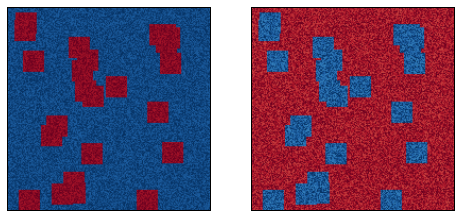

In [3]:
fig = pyplot.figure(figsize=(8,5))
pyplot.subplot(121)
pyplot.imshow(Ui, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);
pyplot.subplot(122)
pyplot.imshow(Vi, cmap = cm.RdBu)
pyplot.xticks([]), pyplot.yticks([]);

In [4]:
n = 192
Du, Dv, F, k = 0.00016, 0.00008, 0.035, 0.065 # Bacteria 1 
dh = 5./(n-1)
T = 8000
dt = .9 * dh**2 / (4*max(Du,Dv))
nt = int(T/dt)

In [5]:
def ftcs(Ui, Vi, nt, dt, dh, Du, Dv, F, k, n):
    """Does the thing to solve the problem
    
    Parameters:
    -----------
    
    
    Returns:
    --------
    
    """
    # initialize solution and interation array
    ut = numpy.ndarray((nt,n,n))
    ut[0] = Ui
    
    vt = numpy.ndarray((nt,n,n))
    vt[0] = Vi
    
    un = numpy.zeros((n,n))
    vn = numpy.zeros((n,n))

    for n in range(1,nt):
        un = ut[n-1].copy()
        vn = ut[n-1].copy()
        
        ut[n,1:-1,1:-1] = un[1:-1,1:-1]*(1-4*Du*dt/dh**2) +\
            Du*dt/dh**2*(un[1:-1,2:] + un[1:-1,:-2] + un[2:,1:-1] + un[:-2,1:-1])\
            - dt*(un[1:-1,1:-1]*vn[1:-1,1:-1]**2) + dt*F*(1-un[1:-1,1:-1])
        
        vt[n,1:-1,1:-1] = vn[1:-1,1:-1]*(1-4*Dv*dt/dh**2) +\
            Dv*dt/dh**2*(vn[1:-1,2:] + vn[1:-1,:-2] + vn[2:,1:-1] + vn[:-2,1:-1])\
            + dt*(vn[1:-1,1:-1]*vn[1:-1,1:-1]**2) - dt*(F+k)*vn[1:-1,1:-1] 
        
        # enforce Neumann boundary conditions
        # for U
        ut[n,0,:] = ut[n,1,:]   # bottom boundary
        ut[n,-1,:] = ut[n,-2,:] # top boundary
        ut[n,:,0] = ut[n,:,1]   # left boundary
        ut[n,:,-1] = ut[n,:,-2] # bottom boundary
        # for V
        vt[n,0,:] = vt[n,1,:]   # bottom boundary
        vt[n,-1,:] = vt[n,-2,:] # top boundary
        vt[n,:,0] = vt[n,:,1]   # left boundary
        vt[n,:,-1] = vt[n,:,-2] # bottom boundary
    
    return ut, vt        

In [25]:
Ut, Vt = ftcs(Ui.copy(), Vi.copy(), nt, dt, dh, Du, Dv, F, k, n)

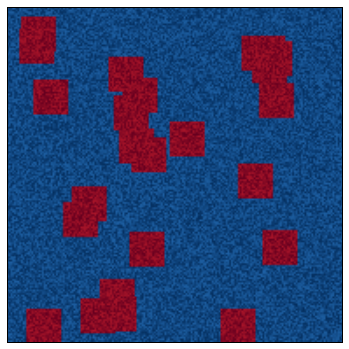

In [7]:
# set up animation frame
fig = pyplot.figure(figsize=(8,6))
pyplot.xticks([]), pyplot.yticks([]);

im = pyplot.imshow(Ui, cmap=cm.RdBu)

In [8]:
def init():
    im.set_data(Ui)
    return im,

def animate(data):
    im.set_array(data)
    return im,

In [88]:
# the first dimensionality of frames should be w.r.t time
anim = animation.FuncAnimation(fig, animate, frames=Ut[:100:], interval=25)

In [89]:
HTML(anim.to_html5_video())

In [92]:
numpy.round(Ut[-1,100,::40],4)

array([ 0.3098,  0.0661,  0.0661,  0.0661,  0.379 ])

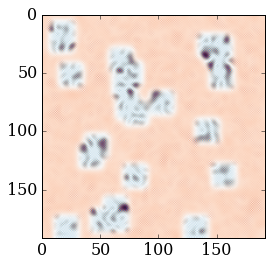

In [102]:
#im.set_array(Ut[500])
#im
pyplot.imshow(Ut[15], cmap=cm.RdBu);